# Getting started with Collimator simulations

The Collimator Python package is a comprehensive tool for modeling and simulating hybrid dynamical systems.  It is designed to be familiar for users of other simulation tools like Simulink and Modelica, but with the added benefit of being able to use Python's extensive scientific computing ecosystem.  It is also based on JAX, which allows for fast simulation via just-in-time (JIT) compilation, automatic differentiation, and scaling to high-performance computing resources, all with a familiar NumPy-like numerical interface.

Putting it all together allows for a modern, flexible, and powerful simulation tool that can be used for a wide variety of applications from classical controller design to cutting-edge data-driven optimization and machine learning applications.  This tutorial will walk through the basics of using Collimator to simulate a simple hybrid dynamical system.

In [1]:
import collimator
from collimator import library

import numpy as np
import matplotlib.pyplot as plt

### Constructing block diagrams

One of the core ideas of the Collimator modeling framework is constructing complex models out of simple building blocks connected together into composite models via the "block diagram" paradigm familiar from control theory.  The Collimator package provides a number of "primitive" blocks, including integrators, gains, and summing junctions, and more complex blocks like neural networks and model-predictive controllers.  These blocks can be connected together to form composable diagrams, which can then be simulated using the `simulate` function.

As a starting point, let's consider a simple model of a mass-spring-damper system.  This system is described by the following differential equation:

$$
m \ddot{x} + b \dot{x} + k x = u,
$$

where $m$ is the mass, $b$ is the damping coefficient, $k$ is the spring constant, and $u$ is the applied force.
For the sake of simplicity, let's take the mass $m$ to be 1 kg and the damping coefficient $b$ to be zero.  The equations of motion then simplify to:

$$
\ddot{x} = u - k x.
$$

We can construct a block diagram representation of this system using simple primitive blocks in Collimator:

<img src="../media/oscillator-plant.png" alt="Oscillator" style="width: 600px;"/>

To start off, we'll skip the "diagram-level" input port "u" and output port "y" and just add a step input to the system like this:

<img src="../media/oscillator-step.png" alt="Oscillator" style="width: 550px;"/>

We can construct this block diagram using the `DiagramBuilder` class, which has a simple interface:

* `add(block)`: add a block to the diagram and return a reference to the block
* `connect(output_port, input_port)`: connect an output port to an input port
* `build()`: construct the diagram and return a reference to it
* `export_input(input_port)`: export an input port to the diagram level
* `export_output(output_port)`: export an output port to the diagram level

We'll return to the port "exporting" methods shortly.  For now, let's start by constructing the block diagram.  It is often a good practice to put the diagram construction code in a function, which allows us to easily reuse the diagram and makes it less likely for stray global variables to cause problems.

In [2]:
def make_oscillator(x0, v0, k):
    # Create a diagram builder
    builder = collimator.DiagramBuilder()

    # Add all the blocks to the diagram
    position = builder.add(library.Integrator(x0, name="position"))
    velocity = builder.add(library.Integrator(v0, name="velocity"))
    spring_constant = builder.add(library.Gain(k, name="spring_constant"))
    net_force = builder.add(library.Adder(2, operators="+-", name="net_force"))
    Step_0 = builder.add(
        library.Step(start_value=0.0, end_value=1.0, step_time=1.0, name="Step_0")
    )

    # Connect the blocks
    builder.connect(position.output_ports[0], spring_constant.input_ports[0])
    builder.connect(Step_0.output_ports[0], net_force.input_ports[0])
    builder.connect(spring_constant.output_ports[0], net_force.input_ports[1])
    builder.connect(net_force.output_ports[0], velocity.input_ports[0])
    builder.connect(velocity.output_ports[0], position.input_ports[0])

    # Build the diagram
    diagram = builder.build(name="oscillator")

    return diagram


# Define some parameters
x0 = 0.0  # Initial position [m]
v0 = 0.0  # Initial velocity [m/s]
k = 10.0  # Spring constant [N/m]

# Create the block diagram
diagram = make_oscillator(x0, v0, k)

# Show the blocks in the diagram
diagram.pprint()

# We can recover the blocks by indexing into the diagram by name
position = diagram["position"]
velocity = diagram["velocity"]
spring_constant = diagram["spring_constant"]
Step_0 = diagram["Step_0"]
net_force = diagram["net_force"]

|-- oscillator
    |-- position(id=1)
    |-- velocity(id=2)
    |-- spring_constant(id=3)
    |-- net_force(id=4)
    |-- Step_0(id=5)


Next let's simulate the system.  To do this, we'll use the `simulate` function, which takes as input the system model and a "context" object containing the time, state, and parameters of the system.  First, let's take a quick look at the context.  We can create a context that matches the system using the `.create_context()` method.

The structure of the context is similar to a dictionary indexed by the "System ID", a unique identifier for each block in the diagram.  Each block has a "state" and "parameters" entry, which are dictionaries containing the state and parameters of the block, respectively.  The "root" context also contains a "time" entry, which is a scalar value representing the current time of the system.

In [3]:
context = diagram.create_context()
print(f"time: {context.time}")

# Extract the context for the "x" integrator block
x_context = context[position.system_id]
print(f"position state: {x_context.state}")

# Extract the context for the gain block
k_context = context[spring_constant.system_id]
print(f"gain state: {k_context.state}")  # No state
print(f"gain parameters: {k_context.parameters}")

time: 0.0
position state: LeafState(xc=0.0)
gain state: LeafState()
gain parameters: {'gain': Array(10., dtype=float64, weak_type=True)}


The "state" part of the context contains several components, including discrete and continuous states, denoted `xd` and `xc` as shorthand in the print statements.  This part of the system only uses the "continuous" state, so named because it evolves continuously in time as prescribed by the ODE.  Each integrator has one continuous state component, so the full continuous state of the system has two components:



In [4]:
context.continuous_state

[Array(0., dtype=float64, weak_type=True),
 Array(0., dtype=float64, weak_type=True)]

The context is immutable, so for instance if we were to try to change the initial condition by assigning to the continuous state we would get an error:

In [5]:
try:
    x_context.continuous_state = 1.0
except Exception as e:
    print(e)

cannot assign to field 'continuous_state'


Instead, we can update and return a new copy of the context using methods like `with_continuous_state`:

In [6]:
updated_context = x_context.with_continuous_state(1.0)
print(updated_context.continuous_state)

# The original is unchanged
print(x_context.continuous_state)

# The diagram context is also unchanged
print(context.continuous_state)

1.0
0.0
[Array(0., dtype=float64, weak_type=True), Array(0., dtype=float64, weak_type=True)]


Next let's set up and run a simulation using the `simulate` function:

collimator:INFO max_major_steps=100 based on smallest discrete period=inf


collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), Dopri5Solver(system=Diagram(oscillator, 5 nodes), rtol=1e-06, atol=1e-08, max_steps=4096, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Text(0, 0.5, 'force [N]')

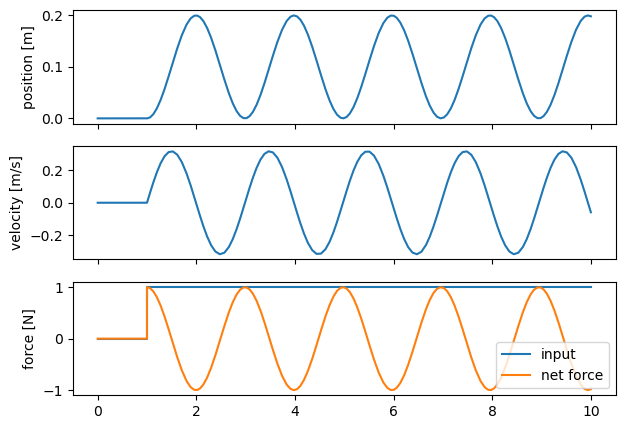

In [7]:
context = diagram.create_context()

recorded_signals = {
    "u": Step_0.output_ports[0],
    "F": net_force.output_ports[0],
    "x": position.output_ports[0],
    "v": velocity.output_ports[0],
}

t0, tf = 0.0, 10.0
results = collimator.simulate(
    diagram,
    context,
    (t0, tf),
    recorded_signals=recorded_signals,
    options=collimator.SimulatorOptions(rtol=1e-6, atol=1e-8),
)

fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
axs[0].plot(results.time, results.outputs["x"])
axs[0].set_ylabel("position [m]")
axs[1].plot(results.time, results.outputs["v"])
axs[1].set_ylabel("velocity [m/s]")
axs[2].plot(results.time, results.outputs["u"], label="input")
axs[2].plot(results.time, results.outputs["F"], label="net force")
axs[2].legend(loc="lower right")
axs[2].set_ylabel("force [N]")

This code should be mostly self-explanatory except for the `recorded_signals` dictionary.  Models can grow to encompass many blocks, each of which may have several ports, while in many practical cases there may only be a few such signals of particular interest. To avoid having to record all signals, the `simulate` function takes a dictionary of "signals" (typically output ports) that should be recorded.  The keys are arbitrary names for the signals (here we chose `"x"` and `"v"`), and the values are references to the block ports.

Finally, the `simulate` function returns an object containing various results, including the time series and the recorded signals.

### Adding a controller

Next let's add in some feedback control to get the system to do what we want.  We could add the controller logic to the same diagram, but this quickly leads to an unmanageable number of blocks and prevents creating "modular" systems on which we can test various controllers, etc.

Instead, it's often better to break the full model into sub-diagrams which represent logical components of the system.  In this example, we can create a reference-tracking PID controller with a top-level diagram that looks like this:

<img src="../media/reference-tracking.png" alt="Reference Tracking" style="width: 600px;"/>

The "plant" is a sub-diagram that we've (almost) already seen how to construct:

<img src="../media/oscillator-plant.png" alt="Oscillator" style="width: 600px;"/>

The last thing we need to cover is the way that the sub-diagram becomes a "block" in the top-level diagram.  We make this happen by "exporting" ports before constructing the diagram.  The `export_input` and `export_output` methods of the `DiagramBuilder` class allow us to export input and output ports, respectively, to the diagram level.  This allows us to connect the sub-diagram to other blocks in the top-level diagram.

Let's see how this works in practice.  First, let's construct the plant sub-diagram:

In [8]:
def make_plant(x0=0.0, v0=0.0, k=10.0, name="plant"):
    builder = collimator.DiagramBuilder()

    # Add all the blocks to the diagram
    position = builder.add(library.Integrator(x0, name="position"))
    velocity = builder.add(library.Integrator(v0, name="velocity"))
    spring_constant = builder.add(library.Gain(k, name="spring_constant"))
    net_force = builder.add(library.Adder(2, operators="+-", name="net_force"))

    # Connect the blocks
    builder.connect(position.output_ports[0], spring_constant.input_ports[0])
    builder.connect(spring_constant.output_ports[0], net_force.input_ports[1])
    builder.connect(net_force.output_ports[0], velocity.input_ports[0])
    builder.connect(velocity.output_ports[0], position.input_ports[0])

    # Export the input and output ports as diagram ports
    builder.export_input(net_force.input_ports[0], "u")
    builder.export_output(position.output_ports[0], "y")

    # Build the diagram
    return builder.build(name=name)

We can use this diagram just like a "primitive" block in the top-level diagram.  For the feedback controller, we'll use a simple discrete-time PID controller that updates at a rate of `dt` seconds.

We don't have to do any further work to make sure these updates are handled properly; the `simulate` function will automatically stop time integration and handle the discrete-time updates for us.  We'll explore discrete and hybrid systems further in future tutorials.

In [9]:
builder = collimator.DiagramBuilder()  # Create a fresh diagram builder

dt = 0.1  # Discrete time step of the PID controller [s]
kp = 10.0  # Proportional gain
ki = 20.0  # Integral gain
kd = 12.0  # Derivative gain
x0 = 1.0  # Initial position [m]
v0 = 0.0  # Initial velocity [m/s]

# Add the blocks to the top-level diagram
plant = builder.add(make_plant(name="plant", x0=x0, v0=v0))
reference_signal = builder.add(
    library.Step(start_value=0.0, end_value=1.0, step_time=5.0, name="reference_signal")
)
tracking_error = builder.add(library.Adder(2, operators="-+", name="tracking_error"))
neg_one = builder.add(library.Gain(-1.0, name="neg_one"))
controller = builder.add(
    library.PIDDiscrete(kp=kp, ki=ki, kd=kd, dt=dt, name="controller")
)

# Connect the blocks
builder.connect(reference_signal.output_ports[0], tracking_error.input_ports[0])
builder.connect(plant.output_ports[0], tracking_error.input_ports[1])
builder.connect(tracking_error.output_ports[0], controller.input_ports[0])
builder.connect(controller.output_ports[0], neg_one.input_ports[0])
builder.connect(neg_one.output_ports[0], plant.input_ports[0])

# Create the diagram
diagram = builder.build(name="root")

# Show the blocks in the diagram.  Note that this time the blocks in the "plant"
# appear nested inside the subdiagram.
diagram.pprint()

|-- root
    |-- plant
        |-- position(id=7)
        |-- velocity(id=8)
        |-- spring_constant(id=9)
        |-- net_force(id=10)
    |-- reference_signal(id=12)
    |-- tracking_error(id=13)
    |-- neg_one(id=14)
    |-- controller(id=15)


Finally, we can simulate it just as we did for the plant-only diagram:

collimator:INFO max_major_steps=198 based on smallest discrete period=0.1
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=198, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), Dopri5Solver(system=Diagram(root, 5 nodes), rtol=1e-06, atol=1e-08, max_steps=4096, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Text(0, 0.5, 'force [N]')

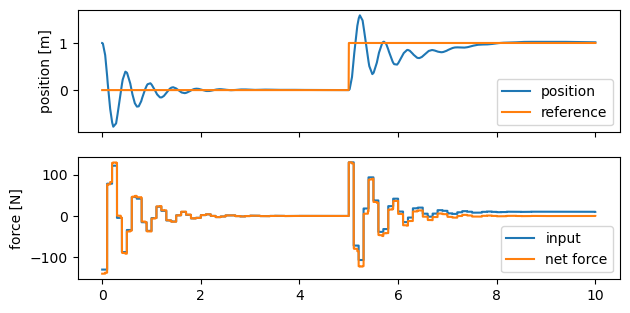

In [12]:
context = diagram.create_context()

recorded_signals = {
    "xr": reference_signal.output_ports[0],
    "u": diagram["neg_one"].output_ports[0],
    "y": diagram["plant"].output_ports[0],
    "F": diagram["plant"]["net_force"].output_ports[0],
}

t0, tf = 0.0, 10.0
results = collimator.simulate(
    diagram,
    context,
    (t0, tf),
    recorded_signals=recorded_signals,
    options=collimator.SimulatorOptions(rtol=1e-6, atol=1e-8),
)

fig, axs = plt.subplots(2, 1, figsize=(7, 3.5), sharex=True)
axs[0].plot(results.time, results.outputs["y"], label="position")
axs[0].plot(results.time, results.outputs["xr"], label="reference")
axs[0].legend(loc="lower right")
axs[0].set_ylabel("position [m]")
axs[1].step(results.time, results.outputs["u"], where="post", label="input")
axs[1].step(results.time, results.outputs["F"], where="post", label="net force")
axs[1].legend(loc="lower right")
axs[1].set_ylabel("force [N]")

The controlled system damps out the natural oscillations and tracks the reference signal through the step change (albeit with large and undesirable variability in the control signal).

Let's recap.  We've seen how to quickly construct block diagram models similar to those in Simulink or Modelica using the built-in blocks available from `library`, including:

* `Gain`
* `Integrator`
* `Adder`
* `Step`
* `PIDDiscrete`

To see a full list of built-in blocks, [see the documentation here](https://py.collimator.ai/library/).

These blocks can be connected together to form diagrams using the `DiagramBuilder` class, which has a simple interface:

* `add(block)`: add a block to the diagram and return a reference to the block
* `connect(output_port, input_port)`: connect an output port to an input port
* `build()`: construct the diagram and return a reference to it
* `export_input(input_port)`: export an input port to the diagram level
* `export_output(output_port)`: export an output port to the diagram level

These diagrams can be treated as blocks themselves in other diagrams, allowing for modular construction of complex systems.

Once the model has been constructed, it can be simulated using the `simulate` function, which takes as input the system model and a "context" object containing the time, state, and parameters of the system.  The `simulate` function returns an object containing various results, including the time series and specified recorded signals.


### Graphical modeling

It quickly becomes tedious and error-prone to construct large, complex models from primitive blocks by adding them one by one and manually connecting them in code.  One alternative is to write custom blocks that lump these primitive operations together; we will cover this in the next tutorial.

An alternative is to use a graphical modeling tool to construct the block diagram.  Collimator also provides a [web-based modeling tool](https://app.collimator.ai) that allows you to construct block diagrams using an intuitive graphical interface.  These models can be simulated in the app itself, or exported to Python code that can be further analyzed or simulated locally just as we have done here.


### Understanding the structure of models

The interface we've just explored scales from models with a single self-contained "block" up to large, complex models with many interconnected blocks and nested subdiagrams.  To understand why this works, it's helpful to understand a little about the way the modeling framework is structured.

All models in Collimator are represented by a "system" object.  There are two main types of systems: "leaf" systems, like the primitive Gain and Integrator blocks, and "diagram" systems, which are composed of other systems. Together, the system object is tree-structured, with the leaf systems as the leaves and the diagram systems as the internal nodes.

For example, the diagram we constructed above is represented by the following tree structure, with the leaf systems in blue and the diagrams in red:

<img src="../media/tree2.jpeg" alt="Diagram tree structure" style="width: 600px;"/>

By design of the "system" class hierarchy, all blocks have a common interface that allows them to be treated uniformly from the perspective of simulation and other kinds of analysis.  For example, all systems support methods including:

* `eval_time_derivatives`: compute the time derivatives of the continuous component of the system state
* `handle_discrete_updates`: compute the periodic updates to the discrete components of the system state
* `handle_zero_crossing_updates`: compute the "reset map" updates to the system state that occur when a zero-crossing event is triggered

Together, these methods define a hybrid dynamical system as a collection of functions.  These functions act on the "context" objects, which are constructed for a particular system and contain the time, state, and parameters of the system.  The implication of the consistent interface is that _every_ block can be a hybrid dynamical system, potentially including discrete and continuous dynamics, zero-crossing events, and other features.  In the next tutorial we will look more closely at the system interface and how to construct custom blocks.

### Configuring simulations

You may have noticed that we overrode the default tolerances in the ODE solver by setting `options=collimator.SimulatorOptions(rtol=1e-6, atol=1e-8)`.  The defaults are `rtol=1e-3` and `atol=1e-6`, matching the defaults in `scipy.integrate.solve_ivp`.  Let's see what happens if we run the simulation again with the defaults:

collimator:INFO max_major_steps=100 based on smallest discrete period=inf
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=0.001, atol=1e-06, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), Dopri5Solver(system=Diagram(oscillator, 5 nodes), rtol=0.001, atol=1e-06, max_steps=4096, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


Text(0, 0.5, 'force [N]')

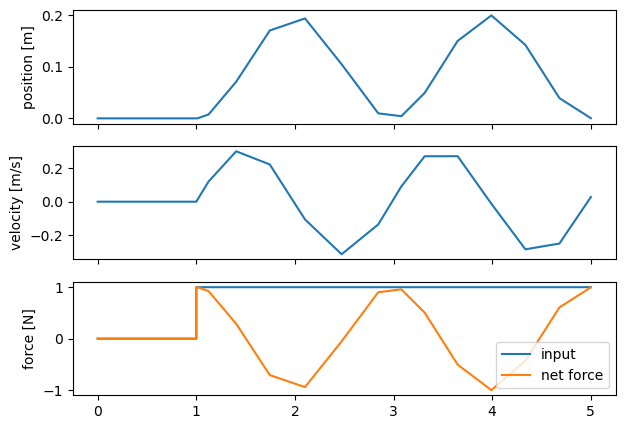

In [14]:
diagram = make_oscillator(x0=0.0, v0=0.0, k=10.0)
context = diagram.create_context()

recorded_signals = {
    "u": diagram["Step_0"].output_ports[0],
    "x": diagram["position"].output_ports[0],
    "v": diagram["velocity"].output_ports[0],
    "F": diagram["net_force"].output_ports[0],
}

t0, tf = 0.0, 5.0
results = collimator.simulate(
    diagram,
    context,
    (t0, tf),
    recorded_signals=recorded_signals,
)

fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
axs[0].plot(results.time, results.outputs["x"])
axs[0].set_ylabel("position [m]")
axs[1].plot(results.time, results.outputs["v"])
axs[1].set_ylabel("velocity [m/s]")
axs[2].plot(results.time, results.outputs["u"], label="input")
axs[2].plot(results.time, results.outputs["F"], label="net force")
axs[2].legend(loc="lower right")
axs[2].set_ylabel("force [N]")

Why does the resolution look so poor in the simulation results?  In fact, the results are not necessarily inaccurate (at least up to the specified tolerances), but are only reported at the times reached by the adaptive time-stepping in the ODE solver.  We can see that by looking at the sampled points directly:

Text(0, 0.5, 'force [N]')

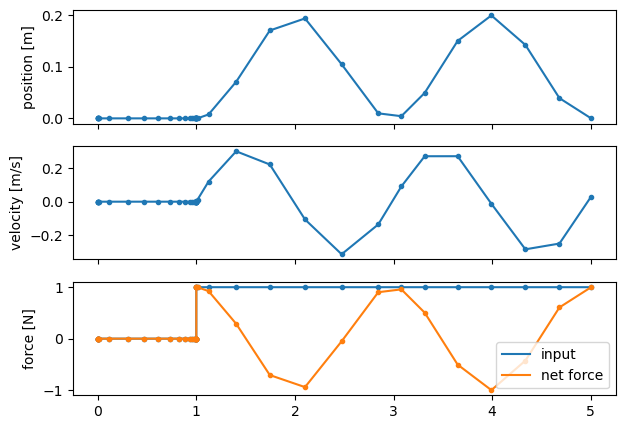

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
(l,) = axs[0].plot(results.time, results.outputs["x"])
axs[0].plot(results.time, results.outputs["x"], ".", color=l.get_color())
axs[0].set_ylabel("position [m]")
(l,) = axs[1].plot(results.time, results.outputs["v"])
axs[1].plot(results.time, results.outputs["v"], ".", color=l.get_color())
axs[1].set_ylabel("velocity [m/s]")
(l,) = axs[2].plot(results.time, results.outputs["u"], label="input")
axs[2].plot(results.time, results.outputs["u"], ".", color=l.get_color())
(l,) = axs[2].plot(results.time, results.outputs["F"], label="net force")
axs[2].plot(results.time, results.outputs["F"], ".", color=l.get_color())
axs[2].legend(loc="lower right")
axs[2].set_ylabel("force [N]")

To understand the sampling, it's helpful to understand a little about the way the hybrid simulation works.  The simulation is broken into "major steps", which constitute intervals of time between events, and "minor steps", which are the steps taken by the ODE solver to advance in continuous time.  The major steps are determined by the following criteria:

* The end time of the simulation
* Scheduled periodic discrete updates
* Localization of zero-crossing events
* The minimum major step length specified manually in `SimulatorOptions`

Within a "major step", the ODE solver may take a number of "minor steps" to advance the continuous state of the system.  For example, the simulation steps for a hybrid system with periodic updates might look like the following:

<img src="../media/sim-steps.jpeg" alt="Simulation steps" style="width: 800px;"/>

Here the major steps are denoted by thicker black lines on the time axis, while the minor steps are indicated by thinner grey lines.  At the boundary of major steps, the system applies the periodic discrete update rules, causing discontinuous jumps in the signal.  In terms of the sampled results, the simulation records results for specified ports at (1) the beginning of each major step, and (2) all intermediate minor steps taken by the ODE solver (solid circles in the figure above).  The final value of each major step is _not_ recorded, so that there are not duplicate results at a particular time stamp (open circles in the figure above).  In the case where there are "zero-crossing" events in the system, the simulation can localize those events in time, leading to additional major steps.  We will discuss event handling in more detail in later tutorials.

Returning to the oscillator example, the ODE solver only _needs_ to take relatively coarse steps to accurately resolve the dynamics of the system, so relatively few minor steps are taken away from the single discrete update induced by the step function.  In the future, we plan to support for interpolation of the results to arbitrary time points, but in the meantime we can use the `SimulatorOptions` to get more fine-grained control over the simulation.

The available options can be found in the documentation for `simulate`:

In [16]:
print(collimator.simulate.__doc__)

Simulate the hybrid dynamical system defined by `system`.

    The parameters and initial state are defined by `context`.  The simulation time
    runs from `tspan[0]` to `tspan[1]`.

    The simulation is "hybrid" in the sense that it handles dynamical systems with both
    discrete and continuous components.  The continuous components are integrated using
    an ODE solver, while discrete components are updated periodically as specified by
    the individual system components. The continuous and discrete states can also be
    modified by "zero-crossing" events, which trigger when scalar-valued guard
    functions cross zero in a specified direction.

    The simulation is thus broken into "major" steps, which consist of the following,
    in order:

    (1) Perform any periodic updates to the discrete state.
    (2) Check if the discrete update triggered any zero-crossing events and handle
        associated reset maps if necessary.
    (3) Advance the continuous state using an ODE 

There are multiple ways of causing the simulation to sample results more frequently.  As above, we could lower the tolerances, causing the adaptive time-stepping to naturally sample more frequently.  A more direct solution is to limit the length of the "minor steps":

collimator:INFO max_major_steps=100 based on smallest discrete period=inf
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=0.001, atol=1e-06, min_minor_step_size=None, max_minor_step_size=0.1, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=4, return_context=True), Dopri5Solver(system=Diagram(oscillator, 5 nodes), rtol=0.001, atol=1e-06, max_steps=4096, max_step_size=0.1, min_step_size=None, method='default', enable_autodiff=False)


Text(0, 0.5, 'force [N]')

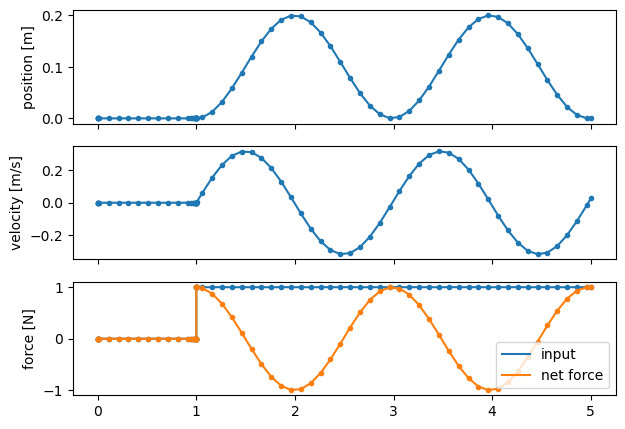

In [17]:
t0, tf = 0.0, 5.0
results = collimator.simulate(
    diagram,
    context,
    (t0, tf),
    recorded_signals=recorded_signals,
    options=collimator.SimulatorOptions(max_minor_step_size=0.1),
)

fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
(l,) = axs[0].plot(results.time, results.outputs["x"])
axs[0].plot(results.time, results.outputs["x"], ".", color=l.get_color())
axs[0].set_ylabel("position [m]")
(l,) = axs[1].plot(results.time, results.outputs["v"])
axs[1].plot(results.time, results.outputs["v"], ".", color=l.get_color())
axs[1].set_ylabel("velocity [m/s]")
(l,) = axs[2].plot(results.time, results.outputs["u"], label="input")
axs[2].plot(results.time, results.outputs["u"], ".", color=l.get_color())
(l,) = axs[2].plot(results.time, results.outputs["F"], label="net force")
axs[2].plot(results.time, results.outputs["F"], ".", color=l.get_color())
axs[2].legend(loc="lower right")
axs[2].set_ylabel("force [N]")

This does not force the simulation to sample at _exactly_ the specified rate, but limits the maximum $\Delta t$ taken by the ODE solver.  Until results interpolation is fully supported, uniform sampling can be achieved by manually interpolating the solution, e.g.

Text(0, 0.5, 'force [N]')

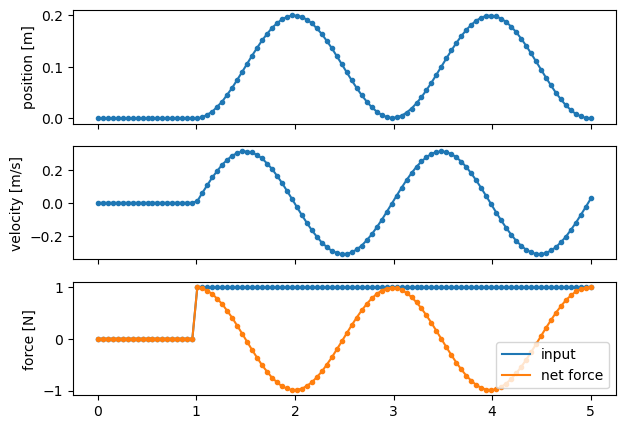

In [18]:
t = np.linspace(t0, tf, 100)
x = np.interp(t, results.time, results.outputs["x"])
v = np.interp(t, results.time, results.outputs["v"])
u = np.interp(t, results.time, results.outputs["u"])
F = np.interp(t, results.time, results.outputs["F"])

fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
(l,) = axs[0].plot(t, x)
axs[0].plot(t, x, ".", color=l.get_color())
axs[0].set_ylabel("position [m]")
(l,) = axs[1].plot(t, v)
axs[1].plot(t, v, ".", color=l.get_color())
axs[1].set_ylabel("velocity [m/s]")
(l,) = axs[2].plot(t, u, label="input")
axs[2].plot(t, u, ".", color=l.get_color())
(l,) = axs[2].plot(t, F, label="net force")
axs[2].plot(t, F, ".", color=l.get_color())
axs[2].legend(loc="lower right")
axs[2].set_ylabel("force [N]")

We will revisit many of the simulation options in later tutorials as we explore more advanced features of hybrid modeling and simulation in Collimator.